# Research topic:   探討2023年的八卦板鄉民對於物價上漲的反應如何

*   **課程:** 社群媒體分析
*   **組別:** 第二組
*   **學生:** M114020036曾國綸、B084020016陳育綺、B065040041蔡瑋駿
*   **爬取資料:** 2023-01-01 到 2023-03-31的PTT八卦板資料
*   **關鍵字:** 物價、物價上漲、通膨、通貨膨脹、薪水

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


+ 1. 文件分類
    - 1.1 斷句
    - 1.2 斷詞
    - 1.3 算出情緒分數，將正負面文章分類
    - 1.4 將情緒標籤加回原本的資料集
    - 1.5 檢視資料集中label的比例
    - 1.6 以7：3的比例切分資料集
    - 1.7 將文章轉換成DTM
        + 1.7.1 使用CountVectorizer + logisticRegression
        + 1.7.2 使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果
    - 1.8 比較不同模型的結果(with cross validation)
+ 2. 主題模型
    + 2.1 資料前處理
        + 2.1.1 將word的欄位轉換成list
        + 2.1.2 建立字典
        + 2.1.3 將斷詞結果建立為corpus
    + 2.2 建立LDA模型（num_topics = 1:10）
        +  2.2.1 觀察perplexity指標
        +  2.2.2 觀察PMI指標
    + 2.3 透過指標找到最佳的主題數（num_topics = 4）
        +  2.3.1 推測四個主題可能為何
+ 3. 社群網路
    + 3.1 取出發文者與推文者的文字
    + 3.2 建立basic_netWork
    + 3.3 建立pers_netWork
    + 3.4 eigenvector centraility(無向圖)
    + 3.5 建立PageRank graph(有向圖)
    + 3.6 建立Hit socre(有向圖)
    + 3.7 建立pers_bet_netWork （betweenness centrality）
    + 3.8 計算最大的subgraph的measure
        +  3.8.1 計算transitivity
        +  3.8.2 計算density
        +  3.8.3 計算distance
        +  3.8.4 計算diameter
        +  3.8.5 計算clustering    

In [ ]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-05-20 04:20:42--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.203.138, 74.125.203.113, 74.125.203.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.203.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c3qr85ra4k217bfrkdqpv7i4p1hcg35t/1684556400000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=eda10b06-1c7c-47a7-9882-8a94ed2eea28 [following]
--2023-05-20 04:20:44--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c3qr85ra4k217bfrkdqpv7i4p1hcg35t/1684556400000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=eda10b06-1c7c-47a7-9882-8a94ed2eea28
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0k

In [ ]:
#%pip install pyvis networkx pyLDAvis

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import pprint
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import re
import pyvis
import networkx as nx
import IPython

#1.文件分類

In [ ]:
#Import the dataset
MetaData = pd.read_csv('/content/drive/MyDrive/社群媒體分析/期中報告/data/SNA_midProject_group2.csv', encoding='UTF-8')
MetaData = MetaData.rename(columns={"artContent": "sentence"})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.1 斷句

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是...也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [ ]:
# 篩選需要的欄位
MetaData['content'] = MetaData['artTitle'] + MetaData['sentence']
MetaData = MetaData.dropna() #去掉空白欄位
data = MetaData[['content','artUrl']] #文章內容

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1)
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

<ipython-input-17-068f4df92739>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1)


,sentence,artUrl,document
0,[問卦]為啥日本相比台灣薪資高物價卻便宜？,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,0
0,如題啦,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,1
0,最近看了一些IG影片,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,2


### 1.2 斷詞

*   去除標點符號
*   去除停用字
*   過濾掉出現太少的字詞



In [ ]:
# We've added some ptt-related terms in the stopwords dict (e.g. 水桶、未滿、中文字...等)
with open('/content/drive/MyDrive/社群媒體分析/期中報告/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_tokens(text):
    
    # 去除noise 斷詞
      text = re.sub("[\t]{2,}", "", text)         # 去除兩個以上空格或tab
      text = re.sub("&.*;", "", text)           # 去除html特殊字元編碼
      text = re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', text)
      text = re.sub("<\w\+\w{4,}>", "", text)         # 去除阿拉伯數字
      text = re.sub("#_*", "", text)            # 去除一個或多個_
      text = re.sub("\\n", " ", text)           # 去除換行
      text = re.sub("\s{2,}", " ", text)         # 去除多個空格
      text = re.sub("^\\s+|\\s+$", "", text)        # 去除開頭/結尾有一個或多個空格(+:一次以上)
      text = re.sub('[^a-zA-Z\u4e00-\u9fa5]+', '', text)


      words = list(jieba.cut(text)) # 斷詞
      words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
      return " ".join(words)

In [ ]:
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence']), axis=1) 

#去除掉clean_txt中包含空字串的任何row_data
data = data[data['clean_txt'].str.strip().astype(bool)]
data.head(5)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.621 seconds.
DEBUG:jieba:Loading model cost 1.621 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,sentence,artUrl,document,clean_txt
0,[問卦]為啥日本相比台灣薪資高物價卻便宜？,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,0,日本 相比 台灣 薪資 高物價 便宜
0,最近看了一些IG影片,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,2,最近 IG 影片
0,介紹了一下日本東京外食,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,3,介紹 一下 日本 東京 外食
0,很多都比台灣便宜,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,4,台灣 便宜
0,不然就是差不多 量卻很多 CP很高的感覺,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,5,CP 感覺


In [ ]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

<ipython-input-25-6a94f2662065>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list


,document,word
0,0,日本
1,0,相比
2,0,台灣
3,0,薪資
4,0,高物價


### 1.3 算出情緒分數，將正負面文章分類
*   透過LIWC字典，將文章分成正負面



In [ ]:
liwc_dict = pd.read_csv("/content/drive/MyDrive/社群媒體分析/期中報告/dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [ ]:
# 統計文章情緒
senti_df = pd.merge(token_df, liwc_dict, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,affect,anger,anx,negative,positive,sad,label
0,20,1.0,0.0,0.0,1.0,0.0,0.0,neg
1,22,1.0,0.0,1.0,1.0,0.0,0.0,neg
2,24,3.0,0.0,0.0,1.0,1.0,0.0,pos
3,25,2.0,0.0,0.0,0.0,2.0,0.0,pos
4,26,1.0,0.0,0.0,0.0,1.0,0.0,pos


## 1.4 將情緒標籤加回原本的資料集


*   把情緒標籤加回去
*   如果該篇文章沒有情緒字，就算是中性的文章



In [ ]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.rename(columns={"clean_txt": "words"})
data_senti.drop(['artUrl', 'sentence', 'document'], axis=1, inplace=True)
data_senti.head(5)

,clean_txt,label
0,日本 相比 台灣 薪資 高物價 便宜,neu
1,最近 IG 影片,neu
2,介紹 一下 日本 東京 外食,neu
3,台灣 便宜,neu
4,CP 感覺,neu


## 1.5 檢視label的比例


*   由於data imbalance的情形非常嚴重，故使用針對情緒為「中性」的欄位使用undersampling




In [ ]:
print(f"category: \n{data_senti['label'].value_counts()}")

category: 
label
neu    70649
pos    10611
neg     8374
Name: count, dtype: int64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# 建立一個undersampler物件，指定要下採樣的比例
rus = RandomUnderSampler(sampling_strategy={'neu': 10000})

# 將data_senti中除了label以外的欄位當作features，label欄位當作target
X = data_senti.drop('label', axis=1)
y = data_senti['label']

# 使用undersampler進行下採樣，並儲存下採樣後的features和target
X_resampled, y_resampled = rus.fit_resample(X, y)

# 將下採樣後的features和target合併為一個新的資料框架
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
print(f"category: \n{resampled_df['label'].value_counts()}")

category: 
label
pos    10611
neu    10000
neg     8374
Name: count, dtype: int64


In [ ]:
resampled_df = resampled_df.rename(columns={"clean_txt": "words"})
resampled_df.to_csv('/content/drive/MyDrive/社群媒體分析/期末報告/data/resampled_data.csv', index=False)

## 1.6 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [ ]:
data = resampled_df
X = data["words"]
y = data["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

9227     英國 首相 蘇納克談 老師 政府 給的 薪資 最高 包括 還為 得到 教師證
28048                                        聰明
22141                  勞動 基金 炒股 醜聞幕 操盤 團隊 何方 神聖
28029                             俄羅斯 歐盟 將始終 重要
25625            種便 當一 款款 試吃 考察 找出 便當 優勢 別家店 差異
Name: words, dtype: object
9227     neu
28048    pos
22141    pos
28029    pos
25625    pos
Name: label, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['label'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
label
pos    36.608591
neu    34.500604
neg    28.890806
Name: proportion, dtype: float64

train percentage :
label
pos    36.561684
neu    34.565528
neg    28.872788
Name: proportion, dtype: float64

test percentage :
label
pos    36.718031
neu    34.349126
neg    28.932843
Name: proportion, dtype: float64


## 1.7 將文章轉換成DTM

### 1.7.1 使用CountVectorizer + logisticRegression

In [ ]:
vectorizer = CountVectorizer(max_features=1000)

In [ ]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
### 用 `toarray()` 轉成 numpy array
# 每個row為每篇文章；每個column為term
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(20289, 1000)
(8696, 1000)


In [ ]:
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['pos' 'pos' 'pos' 'neu' 'neu' 'neu' 'pos' 'neg' 'neg' 'neu']


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.91      0.72      0.80      2516
         neu       0.70      0.95      0.80      2987
         pos       0.96      0.79      0.87      3193

    accuracy                           0.82      8696
   macro avg       0.85      0.82      0.82      8696
weighted avg       0.85      0.82      0.83      8696



(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'neg'), Text(0, 1.5, 'neu'), Text(0, 2.5, 'pos')])

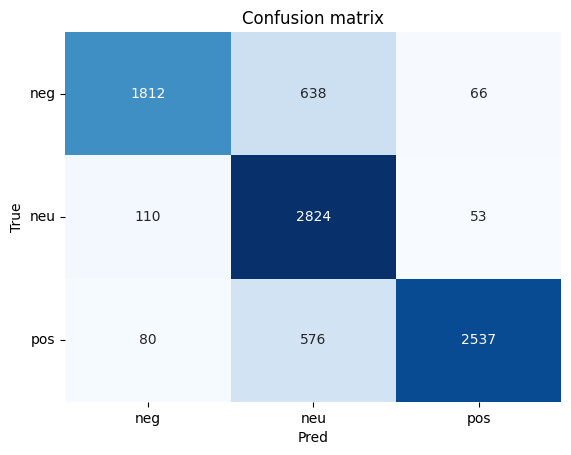

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)

## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [ ]:
# one-hot encoding
# 因為分類器有三種output，為了畫出ROC CURVE而使用one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

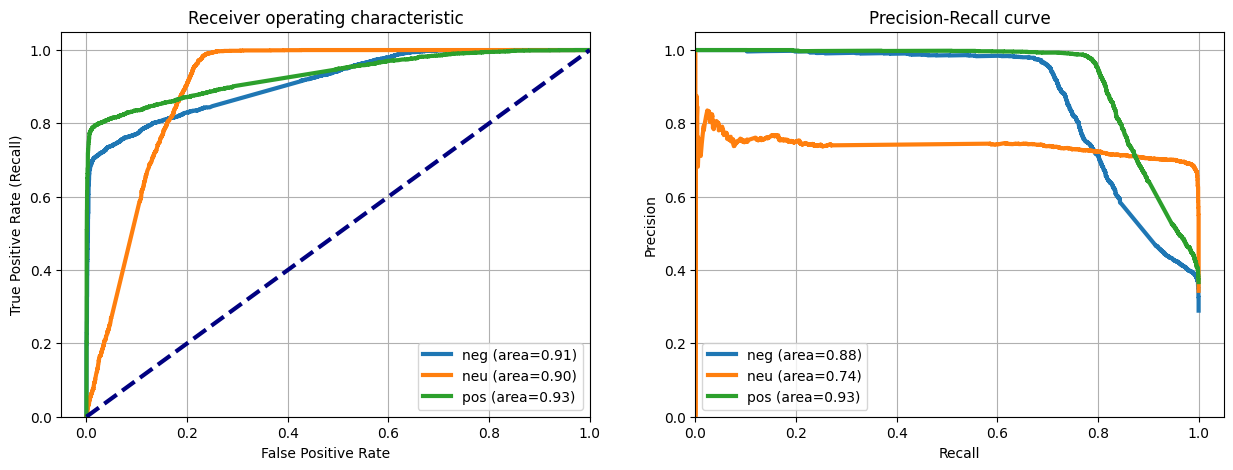

In [ ]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


### 1.7.2 使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         neg       0.91      0.72      0.80      2516
         neu       0.70      0.94      0.80      2987
         pos       0.95      0.79      0.86      3193

    accuracy                           0.82      8696
   macro avg       0.85      0.82      0.82      8696
weighted avg       0.85      0.82      0.82      8696



## 1.8 比較不同模型的結果(with cross validation)

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

now training: clf_logistic
              precision    recall  f1-score   support

         neg       0.90      0.72      0.80      5858
         neu       0.71      0.94      0.81      7013
         pos       0.94      0.80      0.87      7418

    accuracy                           0.83     20289
   macro avg       0.85      0.82      0.83     20289
weighted avg       0.85      0.83      0.83     20289



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

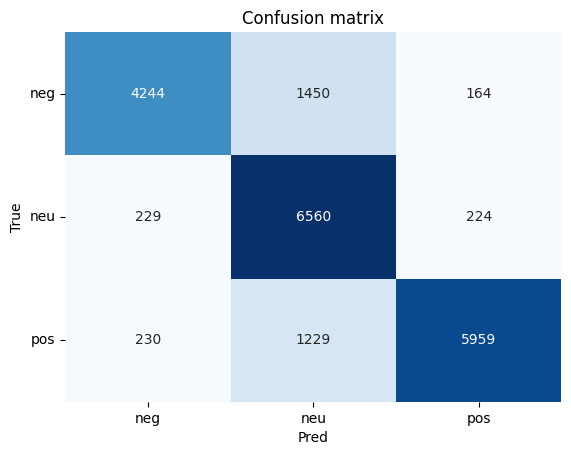

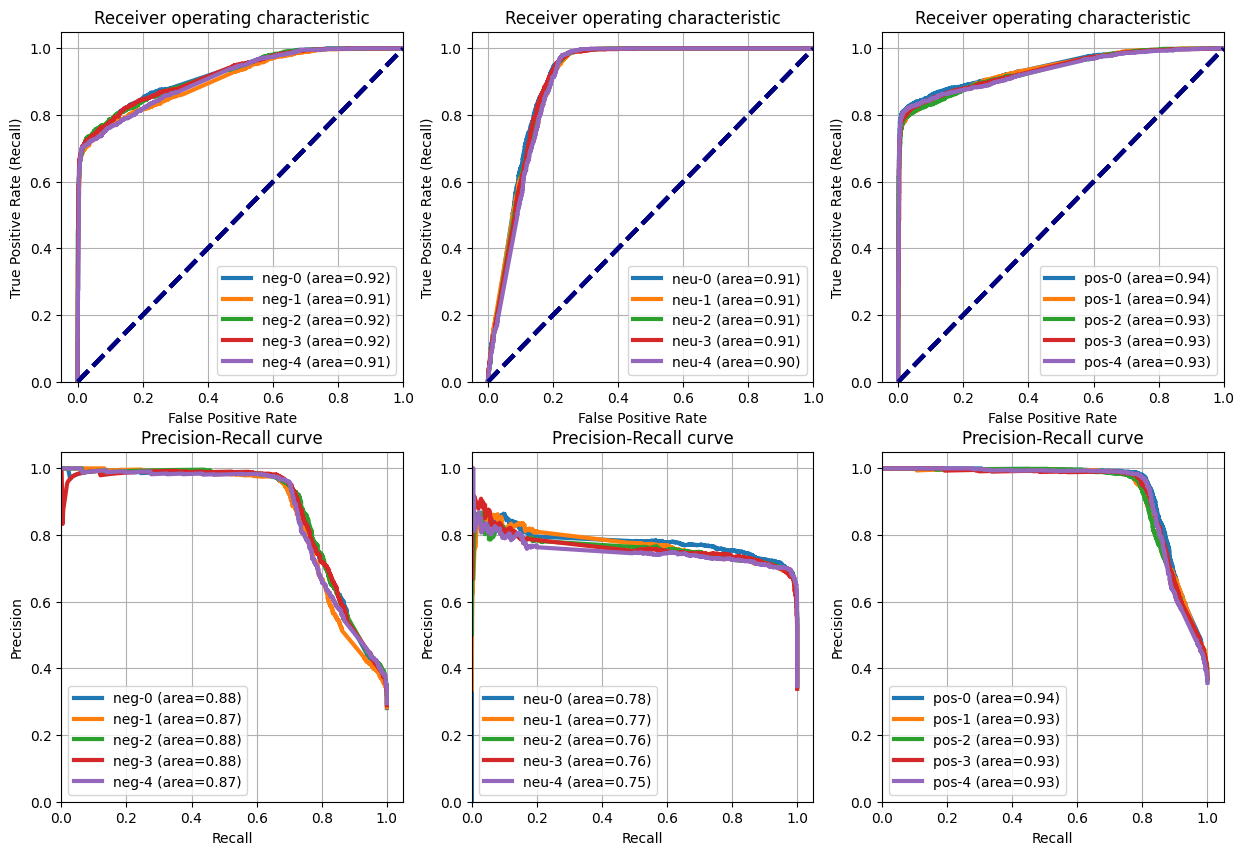

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


now training: clf_dtree
              precision    recall  f1-score   support

         neg       0.80      0.74      0.77      5858
         neu       0.72      0.84      0.77      7013
         pos       0.89      0.80      0.84      7418

    accuracy                           0.80     20289
   macro avg       0.80      0.79      0.80     20289
weighted avg       0.81      0.80      0.80     20289



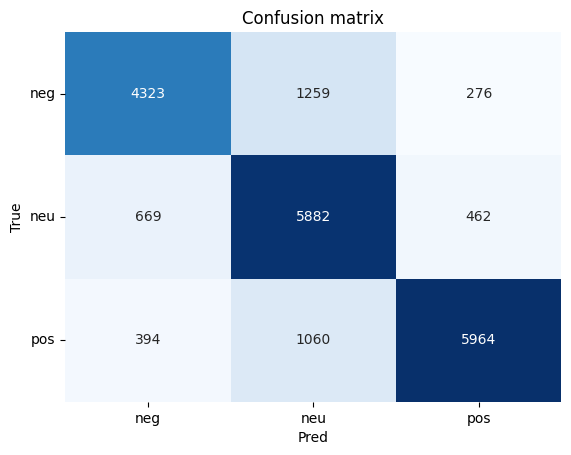

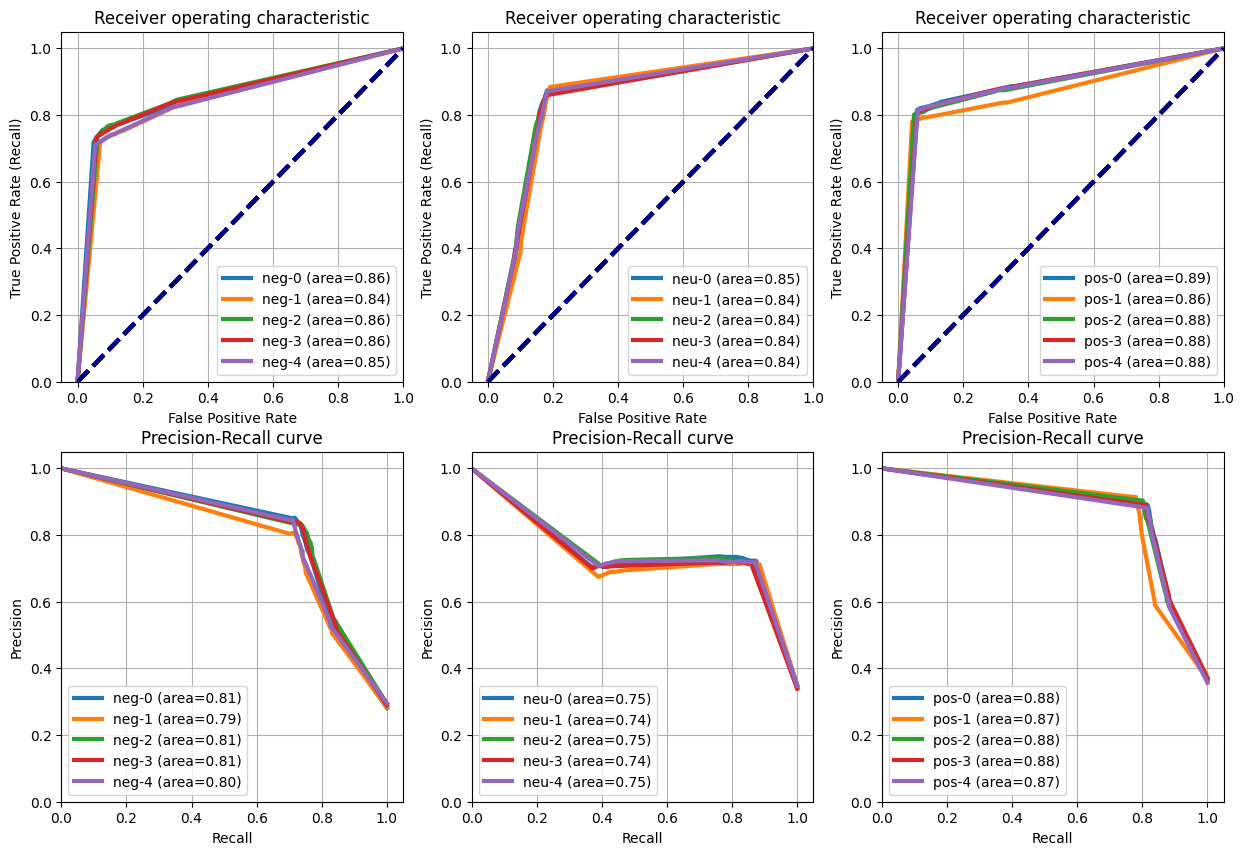

now training: clf_rf
              precision    recall  f1-score   support

         neg       0.87      0.73      0.79      5858
         neu       0.71      0.92      0.80      7013
         pos       0.94      0.80      0.86      7418

    accuracy                           0.82     20289
   macro avg       0.84      0.82      0.82     20289
weighted avg       0.84      0.82      0.82     20289



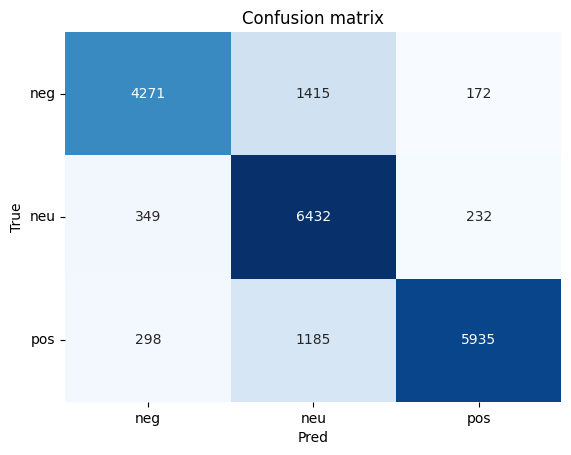

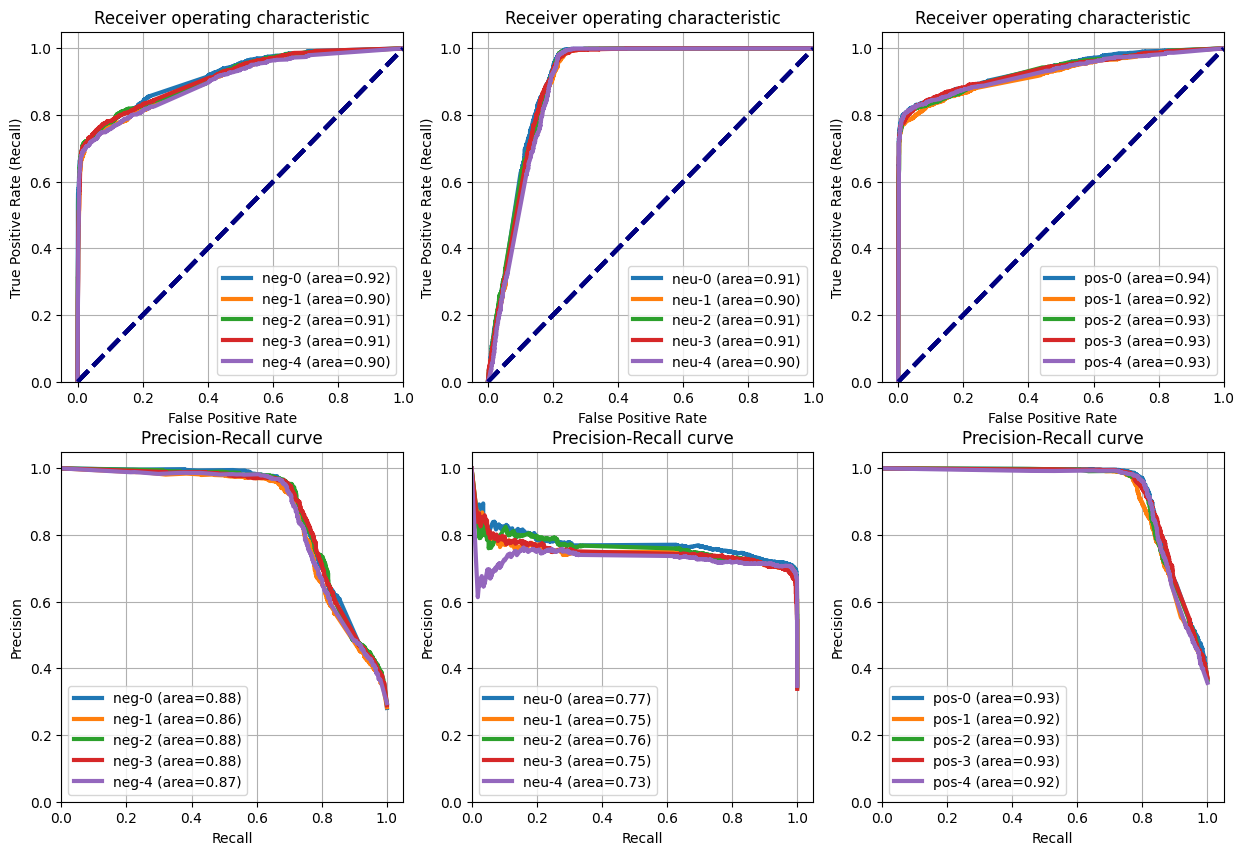

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")

best model: clf_logistic


In [ ]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.92      0.71      0.80      2541
         neu       0.71      0.95      0.82      3047
         pos       0.95      0.81      0.88      3189

    accuracy                           0.83      8777
   macro avg       0.86      0.83      0.83      8777
weighted avg       0.86      0.83      0.83      8777



## 1.9 分析可解釋模型的結果

### 1.9.1 各字詞特徵的estimate係數
+    對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響

In [ ]:
model_set[best_model_name]

LogisticRegression()

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

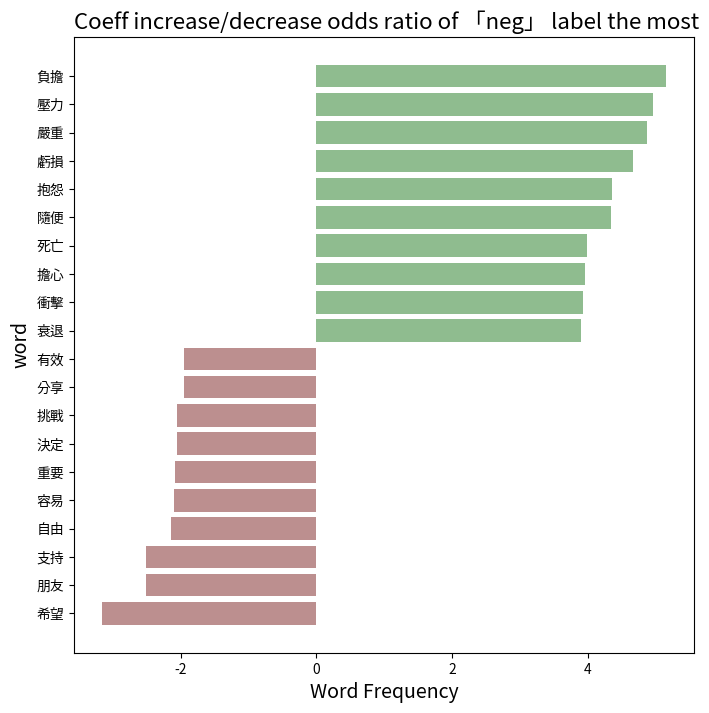

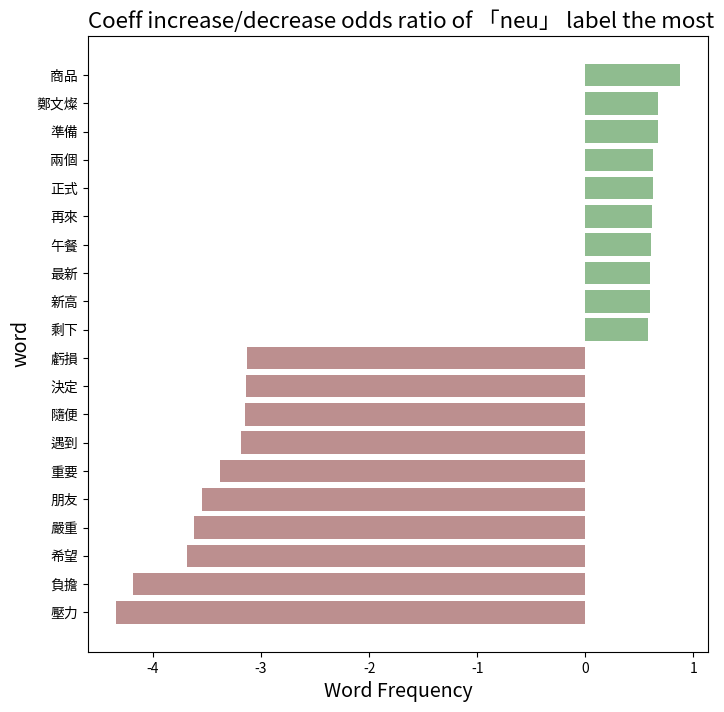

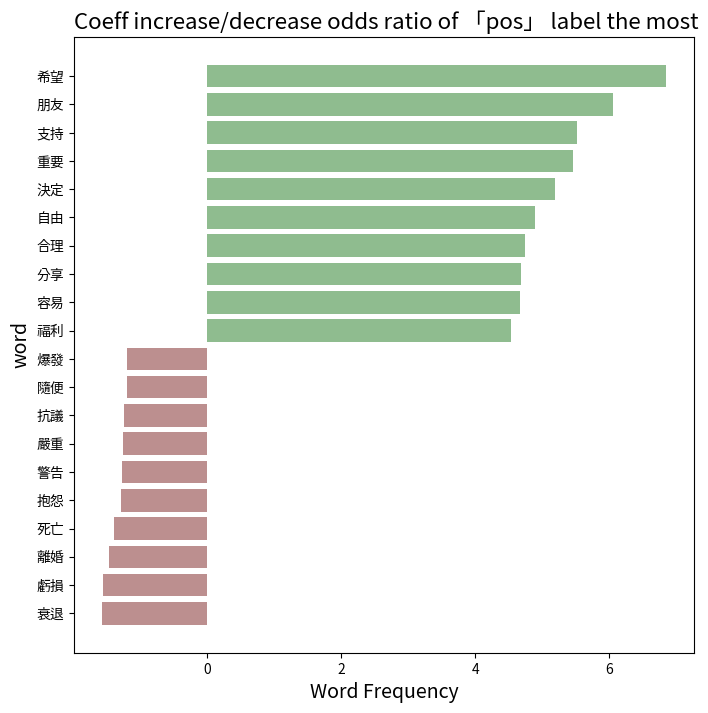

In [ ]:
## When sklearn.__version__ >= 1.0.x use following method：get_feature_names_out(
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names_out(), top_n=10)



*   負面文章：前十大影響字與我們的主題高度相關(ex: 壓力、負擔、虧損)
*   正面文章：與期中報告跑出來的正面文章常用辭彙大致相同
*   中性文章：：前十大影響字有點像是描述產品與物價的狀態



# 2.主題模型

In [ ]:
lda_data = MetaData.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1 資料前處理

In [ ]:
def get_tokens_2(text):
    
    # 去除noise 斷詞
      text = re.sub("[\t]{2,}", "", text)         # 去除兩個以上空格或tab
      text = re.sub("&.*;", "", text)           # 去除html特殊字元編碼
      text = re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', text)
      text = re.sub("<\w\+\w{4,}>", "", text)         # 去除阿拉伯數字
      text = re.sub("#_*", "", text)            # 去除一個或多個_
      text = re.sub("\\n", " ", text)           # 去除換行
      text = re.sub("\s{2,}", " ", text)         # 去除多個空格
      text = re.sub("^\\s+|\\s+$", "", text)        # 去除開頭/結尾有一個或多個空格(+:一次以上)
      text = re.sub('[^a-zA-Z\u4e00-\u9fa5]+', '', text)


      words = list(jieba.cut(text)) # 斷詞
      words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
      return words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:7: DeprecationWarning: invalid escape sequence '\w'
<>:10: DeprecationWarning: invalid escape sequence '\s'
<>:7: DeprecationWarning: invalid escape sequence '\w'
<>:10: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-45-f8d4f68f9cd8>:7: DeprecationWarning: invalid escape sequence '\w'
  text = re.sub("<\w\+\w{4,}>", "", text)         # 去除阿拉伯數字
<ipython-input-45-f8d4f68f9cd8>:10: DeprecationWarning: invalid escape sequence '\s'
  text = re.sub("\s{2,}", " ", text)         # 去除多個空格


In [ ]:
lda_data["words"] = lda_data["sentence"].apply(get_tokens_2)
lda_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource,words
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672509308....,[問卦]為啥日本相比台灣薪資高物價卻便宜？,2023-01-01 01:55:06,peterlin495,Gossiping,如題啦\n\n最近看了一些IG影片\n\n介紹了一下日本東京外食\n\n很多都比台灣便宜\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mastoid"", ""c...",111.71.30.250,2023-01-02 01:26:38,ptt,"[最近, IG, 影片, 介紹, 一下, 日本, 東京, 外食, 台灣, 便宜, CP, 感..."
1,2,https://www.ptt.cc/bbs/Gossiping/M.1672534782....,[新聞]快訊／蔡英文揭新年4目標：規劃房貸補貼,2023-01-01 08:59:39,lovea,Gossiping,1.媒體來源:\nettoday\n\n2.記者署名:\n記者呂晏慈／台北報導\n\n3.完...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""matico"", ""cm...",125.231.180.92,2023-01-02 01:27:37,ptt,"[ettoday, 呂晏慈, 英文, 新年, 目標, 規劃, 房貸, 補貼, 縣市, 交通,..."
2,3,https://www.ptt.cc/bbs/Gossiping/M.1672536891....,[新聞]翁達瑞挨告回台面對官司到中山大學演,2023-01-01 09:34:49,asppsa,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n2.記者署名:\n記者許麗娟／\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""greensaru"", ...",111.82.79.128,2023-01-02 01:27:53,ptt,"[許麗娟, 挨告, 台面, 官司, 中山, 大學演, 講內文, 旅美, 學者, 臉書以, 筆..."
3,4,https://www.ptt.cc/bbs/Gossiping/M.1672537600....,[問卦]慟！！巷口早餐店元月一日全品項漲5元,2023-01-01 09:46:32,a520,Gossiping,淦！\n\n漲了！又漲了！\n\n去年蛋價漲。加蛋5元漲10元\n\n現在全部再漲5元\n\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""horseorange""...",101.12.16.80,2023-01-02 01:27:53,ptt,"[去年, 蛋價漲, 加蛋元, 漲元現, 漲元現, 加蛋要, 卡拉, 鐵板, 奶茶, 要元紅,..."
4,5,https://www.ptt.cc/bbs/Gossiping/M.1672538094....,[新聞]還稅於民？暫不發錢了！蔡英文：需未雨,2023-01-01 09:54:52,kinjk01,Gossiping,TVBS\n方炳超\n還稅於民？暫不發錢了！蔡英文：需未雨綢繆盼國人理解\n今（1）日是20...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""soulknight"",...",223.140.20.127,2023-01-02 01:28:01,ptt,"[TVBS, 方炳超, 還稅, 民暫, 發錢, 英文, 需未雨綢, 繆盼, 國人, 理解, ..."


### 2.1.1 將word的欄位轉換成list

In [ ]:
docs = lda_data['words'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.1.2 建立字典

In [ ]:
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<9745 unique tokens: ['CP', 'IG', '一下', '三倍', '人力']...>


### 2.1.3 將斷詞結果建立為corpus

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.2 建立LDA模型 (num_topics = 1:10)

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

花費時間: 197.63737201690674 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3636.886556,0.031445
1,3,3544.271469,0.016141
2,4,3491.952090,0.009007
3,5,3502.380361,0.018636
4,6,3514.988839,0.034176
5,7,3580.285844,0.009864
6,8,3568.561032,-0.021828
7,9,3622.205671,-0.038261


### 2.2.1 觀察Perplexity指標
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

<Axes: xlabel='topic_num'>

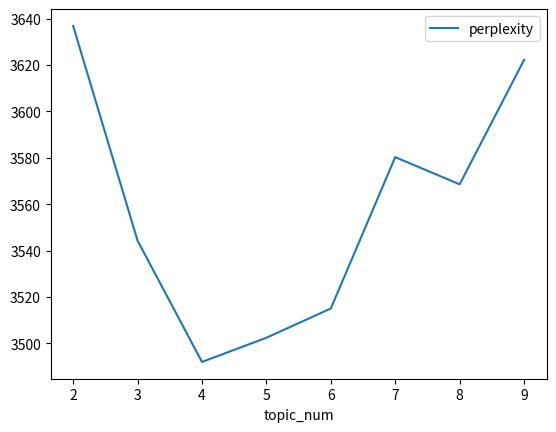

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

### 2.2.2 觀察PMI指標
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。

<Axes: xlabel='topic_num'>

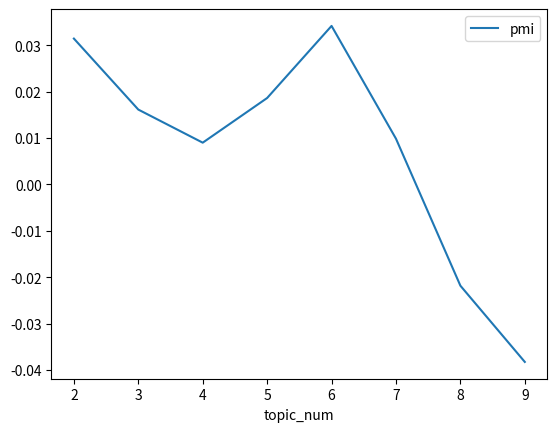

In [ ]:
result.plot.line(x='topic_num', y='pmi')

## 2.3 透過指標找到最佳的主題數（num_topics = 4）


In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.154733 -0.040421       1        1  29.577777
3     -0.106448 -0.152235       2        1  26.775945
2      0.117640  0.077639       3        1  23.440205
0     -0.165925  0.115017       4        1  20.206073, topic_info=    Term         Freq        Total Category  logprob  loglift
217   工作  1830.000000  1830.000000  Default  30.0000  30.0000
19    薪水  2674.000000  2674.000000  Default  29.0000  29.0000
375   電價   732.000000   732.000000  Default  28.0000  28.0000
894   升息   878.000000   878.000000  Default  27.0000  27.0000
732   價格   916.000000   916.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
62    去年   234.994412   774.360305   Topic4  -5.6213   0.4067
83    成長   181.379795   354.560322   Topic4  -5.8803   0.9289
904   指出   209.579163   649.939880   Topic4  -5.7358   0.4674
360   認為   198.496908   617.209639   Topic4  -5.7901   0.4648
96    政府   235.116131  1924.693199   Topic4  -5.6208  -0.5033

[335 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
2502      2  0.873700                     CPI
2502      4  0.125532                     CPI
2542      3  0.969662                      IC
969       1  0.833158  SentfromJPTTonmyiPhone
969       2  0.092573  SentfromJPTTonmyiPhone
...     ...       ...                     ...
262       2  0.091110                      高中
262       3  0.874653                      高中
3075      3  0.983922                      高利
3075      4  0.006693                      高利
8833      4  0.975078                      鮑爾

[745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [ ]:
best_model.print_topics()

[(0,
  '0.011*"經濟" + 0.010*"升息" + 0.008*"台灣" + 0.008*"美國" + 0.007*"央行" + 0.006*"利率" + 0.005*"全球" + 0.005*"影響" + 0.005*"國家" + 0.005*"銀行"'),
 (1,
  '0.018*"薪水" + 0.017*"台灣" + 0.007*"日本" + 0.007*"知道" + 0.006*"房子" + 0.005*"一堆" + 0.005*"工作" + 0.005*"生活" + 0.005*"是不是" + 0.005*"有人"'),
 (2,
  '0.017*"工作" + 0.012*"薪水" + 0.009*"公司" + 0.004*"知道" + 0.004*"薪資" + 0.004*"台灣" + 0.004*"學生" + 0.004*"時間" + 0.004*"需要" + 0.003*"考生"'),
 (3,
  '0.014*"政府" + 0.013*"台灣" + 0.010*"物價" + 0.010*"價格" + 0.008*"電價" + 0.007*"成本" + 0.006*"調漲" + 0.005*"去年" + 0.005*"日本" + 0.005*"經濟"')]

### 2.3.1 推測四個主題可能為何

*   **主題一**：主題一可能與全球經濟、貨幣政策、利率等相關的主題有關。
*   **主題二**：主題二可能與薪資、就業、生活費用等相關的主題有關。
*   **主題三**：主題三可能與工作、職涯發展、薪資待遇等相關的主題有關。
*   **主題四**：主題四可能與政府政策、物價調整、成本等相關的主題有關。



##2.4 GuidedLDA

In [ ]:
#pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

In [ ]:
import guidedlda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vocab = tuple(dictionary.token2id.keys())
word2id = dictionary.token2id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('CP', 'IG', '一下', '三倍', '人力', '介紹', '便宜', '台灣', '同等', '壓低')

In [ ]:
seed_topic_list = [
    ["經濟", "升息", "全球", "央行", "利率"],
    ["薪水", "就業", "工作", "房子"],
    ["工作", "薪水", "公司", "學生", "薪資"],
    ["政府", "台灣", "物價", "電價", "價格"]
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 經濟 去年 今年 影響 升息 台灣 政府 市場 全球 指出
Topic 1: 政府 台灣 中國 認為 提供 社會 總統 要求 希望 英國
Topic 2: 薪水 工作 台灣 公司 知道 生活 一堆 這種 不到 看到
Topic 3: 台灣 物價 價格 日本 成本 政府 電價 便宜 調漲 漲價


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.103806 -0.179709       1        1  38.078546
0      0.011335  0.270095       2        1  23.879495
1      0.297248 -0.080126       3        1  19.843397
3     -0.204777 -0.010260       4        1  18.198562, topic_info=    Term         Freq        Total Category  logprob  loglift
19    薪水  3076.000000  3076.000000  Default  30.0000  30.0000
732   價格   970.000000   970.000000  Default  29.0000  29.0000
122   物價  1452.000000  1452.000000  Default  28.0000  28.0000
217   工作  1879.000000  1879.000000  Default  27.0000  27.0000
140   經濟  1396.000000  1396.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
863   房價   207.673138   717.127924   Topic4  -5.6403   0.4645
416   東西   179.718483   404.479048   Topic4  -5.7848   0.8926
206   國家   183.712005   699.189084   Topic4  -5.7629   0.3673
763   市場   180.716863   641.296087   Topic4  -5.7793   0.4373
627   平均   180.716863   681.221294   Topic4  -5.7793   0.3769

[307 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2502      2  0.919921  CPI
2502      4  0.080919  CPI
4144      1  0.968317   PO
4144      4  0.032745   PO
2         1  0.810911   一下
...     ...       ...  ...
261       4  0.085306   香港
696       2  1.000156  體產業
1574      1  0.985475   高薪
1574      4  0.015560   高薪
1847      3  1.000469  高雄市

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

# 3.社群網絡分析

In [ ]:
raw_data=MetaData.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3.1 篩選部分文章


*   只取有回覆過的文章
*   由於資料集中的文章數目較多，故只取1/30



In [ ]:
##只取有回覆過的文章
raw_data = raw_data[raw_data.artComment != '[]']

##由於文章數量較多，顧取其1/30
raw_data = raw_data.sample(round(raw_data.shape[0]/30))
print(raw_data.shape)
raw_data.head()

(150, 11)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource
2656,2657,https://www.ptt.cc/bbs/Gossiping/M.1676978243....,[問卦]同事說經濟太好大家賺太多錢才漲價,2023-02-21 19:17:21,CircusWorld,Gossiping,如題\n\n這幾年 各種東西不斷的開始漲價\n\n無論是雞排、雞蛋、便當、小吃店、電價 還是...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""onolll"", ""cm...",123.205.143.107,2023-02-22 01:36:44,ptt
2233,2234,https://www.ptt.cc/bbs/Gossiping/M.1676392512....,Re:[新聞]2024願當副手？柯文哲回應了：這是政治上,2023-02-15 00:35:08,Seals,Gossiping,原文恕刪；\n\n2022民眾黨最應該思考的事情是，為什麼你所期待的選民，沒有如你預期般地走...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ivanos"", ""cm...",61.227.3.205,2023-02-15 01:25:15,ptt
3267,3268,https://www.ptt.cc/bbs/Gossiping/M.1678199808....,[新聞]真的贏韓國了！南韓「去年國民人均所得」,2023-03-07 22:36:46,proprome,Gossiping,https://www.storm.mg/lifestyle/4751436\n朱斐青\nh...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""s142857"", ""c...",112.104.98.75,2023-03-08 01:44:40,ptt
1123,1124,https://www.ptt.cc/bbs/Gossiping/M.1674452837....,[問卦]台灣最唬爛的公司是哪間？,2023-01-23 13:47:15,ihl123456,Gossiping,話說台灣很多公司其實都很奇葩\n\n常常都能做出一些讓人驚訝的事情\n\n其中很多都包含員工...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Howard61313""...",223.139.184.104,2023-01-24 01:17:40,ptt
2221,2222,https://www.ptt.cc/bbs/Gossiping/M.1676379750....,"[問卦]油電雙漲若拿""比很多國家便宜""當藉口行嗎",2023-02-14 21:02:28,saiulbb,Gossiping,各位E奶 三十公分 帥哥 美女 大家晚安 大家豪ㄛ!!!\n\n就是阿小魯熊熊想到一個有點好...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""orangehb"", ""...",219.85.16.87,2023-02-15 01:23:55,ptt


## 3.2 建立發文者(artPoster)與推文者(cmtPoster)的網路圖


*   嘗試使用前200筆資料繪製網路圖



In [ ]:
def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'cmtStatus': '→', 'cmtPoster': 'onolll', 'cmtContent': ':你不買，我不買', 'cmtDate': '2023-02-21 19:17:00'}
{'cmtStatus': '→', 'cmtPoster': 'adk147852', 'cmtContent': ':換顏色你就懂惹', 'cmtDate': '2023-02-21 19:18:00'}
{'cmtStatus': '噓', 'cmtPoster': 'chiz2', 'cmtContent': ':你同事誰？', 'cmtDate': '2023-02-21 19:19:00'}
{'cmtStatus': '推', 'cmtPoster': 'maticsakura', 'cmtContent': ':換顏色立場就會換了嘻嘻', 'cmtDate': '2023-02-21 19:20:00'}
{'cmtStatus': '→', 'cmtPoster': 'cimlab', 'cmtContent': ':是不是被嗆到痛點', 'cmtDate': '2023-02-21 19:20:00'}
{'cmtStatus': '推', 'cmtPoster': 'coffee112', 'cmtContent': ':等到民進党下臺後希望他嘴臉沒轉彎', 'cmtDate': '2023-02-21 19:21:00'}
{'cmtStatus': '→', 'cmtPoster': 'beartsubaki', 'cmtContent': ':可是台灣的通膨率和全世界比是從低的', 'cmtDate': '2023-02-21 19:26:00'}
{'cmtStatus': '→', 'cmtPoster': 'beartsubaki', 'cmtContent': ':那邊數過來會比較快找到的耶', 'cmtDate': '2023-02-21 19:26:00'}
{'cmtStatus': '→', 'cmtPoster': 'pttenjk', 'cmtContent': ':吃的需求增加?1餐變吃十個便當逆神經病', 'cmtDate': '2023-02-21 19:36:00'}
{'cmtStatus': '噓', 'c

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
link = raw_data[['artComter','artPoster','artUrl']]
link.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artComter,artPoster,artUrl
2656,onolll,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,adk147852,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,chiz2,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,maticsakura,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,cimlab,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,coffee112,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,beartsubaki,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,beartsubaki,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,pttenjk,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....
2656,noyesray,CircusWorld,https://www.ptt.cc/bbs/Gossiping/M.1676978243....


In [ ]:
import networkx as nx

# Create network plot 
G = nx.Graph()

# Sample 200 rows from the 'link' DataFrame
sampled_link = link.sample(n=200, random_state=42)

# Build connections between nodes using apply method
sampled_link.apply(lambda row: G.add_edge(row['artComter'], row['artPoster']), axis=1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1940    None
14      None
2610    None
14      None
277     None
        ... 
2432    None
246     None
2749    None
1651    None
3413    None
Length: 200, dtype: object

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


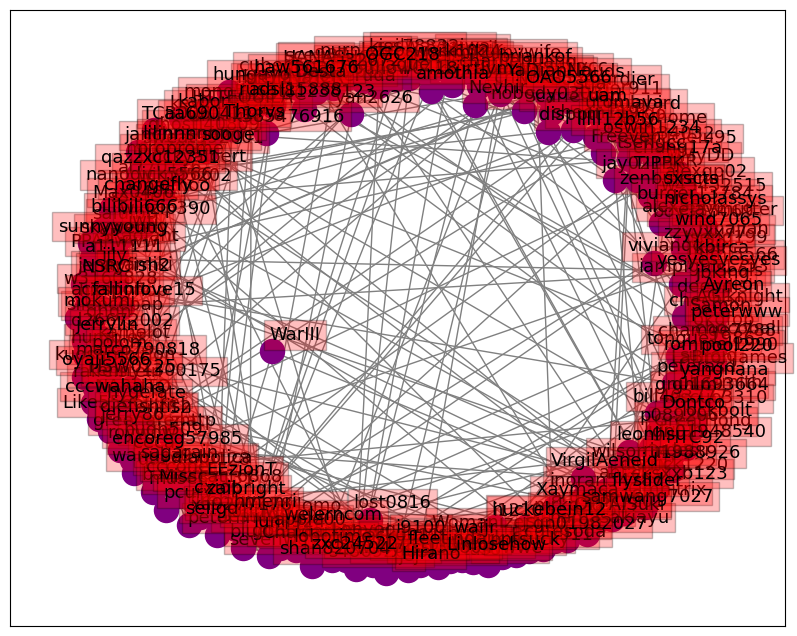

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()